In [ ]:
! pip install -U accelerate
! pip install -U transformers
! pip install evaluate

In [ ]:
import numpy as np
import pandas as pd
import torch
import evaluate
import matplotlib.pyplot as plt

from tensorflow.python.summary.summary_iterator import summary_iterator
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from scipy.special import softmax
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/УИР/Интенциональности.csv")
df.head()

,text,label
0,Что ты думаешь о последних событиях? Хотелось ...,Воволечь в диалог
1,"Мне интересно, как ты видишь эту ситуацию. Мож...",Воволечь в диалог
2,Давай обсудим наши планы на следующий месяц. Ч...,Воволечь в диалог
3,"Я заметил, что ты умеешь решать эту проблему. ...",Воволечь в диалог
4,"Послушай, у меня возникло несколько идей по ул...",Воволечь в диалог


In [ ]:
labels = df.label.unique()
id = range(23)

labels2id = dict(zip(labels, id))
id2labels = dict(zip(id, labels))

In [ ]:
def replace_wrong(s):
  if s == 'Воволечь в диалог':
    return 'Вовлечь в диалог'
  return s

df['label'] = df['label'].apply(replace_wrong)
df.head()

,text,label
0,Что ты думаешь о последних событиях? Хотелось ...,Вовлечь в диалог
1,"Мне интересно, как ты видишь эту ситуацию. Мож...",Вовлечь в диалог
2,Давай обсудим наши планы на следующий месяц. Ч...,Вовлечь в диалог
3,"Я заметил, что ты умеешь решать эту проблему. ...",Вовлечь в диалог
4,"Послушай, у меня возникло несколько идей по ул...",Вовлечь в диалог


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['text'].values, pd.factorize(df['label'].values)[0], test_size=0.25, random_state=42, stratify=df['label'].values)

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=23)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
train_encodings = tokenizer(X_train.tolist(), truncation=True, padding=True)
test_encodings = tokenizer(X_test.tolist(), truncation=True, padding=True)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:
class TorchSet(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TorchSet(train_encodings, y_train)
test_dataset = TorchSet(test_encodings, y_test)


In [ ]:
training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/УИР/model_fine_tuning',
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    evaluation_strategy="steps",
    eval_steps=10,
    logging_dir='/content/drive/MyDrive/УИР/logs',
    logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)


In [ ]:
trainer.train()

Step,Training Loss,Validation Loss
10,3.126400,3.139104
20,3.131700,3.137862
30,3.128800,3.135575
40,3.132700,3.132465
50,3.133100,3.128420
60,3.143400,3.124633
70,3.132400,3.119500
80,3.120000,3.109379
90,3.104800,3.091751
100,3.092400,3.060839


TrainOutput(global_step=755, training_loss=1.6324994737738805, metrics={'train_runtime': 412.9131, 'train_samples_per_second': 29.183, 'train_steps_per_second': 1.828, 'total_flos': 436633189734000.0, 'train_loss': 1.6324994737738805, 'epoch': 5.0})

In [ ]:
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=-1)
accuracy.compute(predictions=preds, references=predictions.label_ids), f1.compute(predictions=preds, references=predictions.label_ids, average="macro")

({'accuracy': 0.914179104477612}, {'f1': 0.9115040148612014})

In [ ]:
def predict(model, tokenizer, text, id2labels):
  device = "cuda" if torch.cuda.is_available() else "cpu"

  encoding = tokenizer(text, return_tensors="pt").to(device)
  outputs = model(**encoding)
  prediction = outputs.logits.argmax(-1)

  probabilities = softmax(outputs['logits'].cpu().detach().numpy()).tolist()[0]
  labels = id2labels.values()

  res = dict()
  prob = dict(zip(labels, probabilities))
  res['probabilities'] = prob
  res['label'] = id2labels[int(prediction)]
  res['text'] = text

  return res

In [ ]:
mytests = ['Владимир Владимирович, можно задать вопрос?',
'Я этого не делал',
'Я не понял объяснения теоремы. Можно кое - что уточнить',
'Сегодня я хочу рассказать о МИФИ 20 лет назад',
'Я хочу быть капитаном команды',
'Наша цель на эту лекцию - доказать теорему Вейерштрасса',
'Вы старались, но эту работу я могу оценить только на 2',
'Можно спросить насчет темы следующей лекции?'
]

for test in mytests:
  print(f"{test} \\\\\\\ {predict(model, tokenizer, test, id2labels)['label']}")

Владимир Владимирович, можно задать вопрос? \\\\ Задавать вопросы
Я этого не делал \\\\ Отрицать
Я не понял объяснения теоремы. Можно кое - что уточнить \\\\ Воволечь в диалог
Сегодня я хочу рассказать о МИФИ 20 лет назад \\\\ Рассказать
Я хочу быть капитаном команды \\\\ Поставить цель
Наша цель на эту лекцию - доказать теорему Вейерштрасса \\\\ Поставить цель
Вы старались, но эту работу я могу оценить только на 2 \\\\ Убедить
Можно спросить насчет темы следующей лекции? \\\\ Задавать вопросы


In [ ]:
text = 'Владимир Владимирович, можно задать вопрос?'
predict(model, tokenizer, text, id2labels)

{'probabilities': {'Воволечь в диалог': 0.0050248075276613235,
  'Выразить надежду': 0.0007574317860417068,
  'Выразить недовольство': 0.0012117319274693727,
  'Выразить обеспокоенность': 0.0007688890327699482,
  'Выразить понимание': 0.0007774985278956592,
  'Выразить своё мнение': 0.0008556910906918347,
  'Выразить согласие': 0.0009292762260884047,
  'Завершить разговор': 0.004169464111328125,
  'Задавать вопросы': 0.8104832172393799,
  'Обратить внимание': 0.009288168512284756,
  'Отрицать': 0.0013423116179183125,
  'Оценить': 0.049268193542957306,
  'Поддержать': 0.00149912282358855,
  'Подтвердить': 0.0018740379018709064,
  'Поставить цель': 0.0020994292572140694,
  'Пояснить': 0.0012730101589113474,
  'Предложить': 0.0509246401488781,
  'Предположить': 0.006382122170180082,
  'Проявить инициативу': 0.03451956808567047,
  'Рассказать': 0.000735512119717896,
  'Убедить': 0.0025555952452123165,
  'Уточнить': 0.012243451550602913,
  'Поделиться опытом': 0.0010169114684686065},
 'labe

In [ ]:
trainer.state.log_history

[{'loss': 3.1264,
  'grad_norm': 2.202059268951416,
  'learning_rate': 1.0000000000000002e-06,
  'epoch': 0.06622516556291391,
  'step': 10},
 {'eval_loss': 3.139103651046753,
  'eval_runtime': 2.9021,
  'eval_samples_per_second': 277.041,
  'eval_steps_per_second': 4.48,
  'epoch': 0.06622516556291391,
  'step': 10},
 {'loss': 3.1317,
  'grad_norm': 2.1415953636169434,
  'learning_rate': 2.0000000000000003e-06,
  'epoch': 0.13245033112582782,
  'step': 20},
 {'eval_loss': 3.137862205505371,
  'eval_runtime': 2.8983,
  'eval_samples_per_second': 277.403,
  'eval_steps_per_second': 4.485,
  'epoch': 0.13245033112582782,
  'step': 20},
 {'loss': 3.1288,
  'grad_norm': 2.0802929401397705,
  'learning_rate': 3e-06,
  'epoch': 0.1986754966887417,
  'step': 30},
 {'eval_loss': 3.1355745792388916,
  'eval_runtime': 2.9106,
  'eval_samples_per_second': 276.229,
  'eval_steps_per_second': 4.466,
  'epoch': 0.1986754966887417,
  'step': 30},
 {'loss': 3.1327,
  'grad_norm': 2.018104314804077,
  

In [ ]:
from tensorflow.python.summary.summary_iterator import summary_iterator
import matplotlib.pyplot as plt


In [ ]:
filename = "/content/drive/MyDrive/УИР/intent_logs/Выразить надежду/events.out.tfevents.1715896146.4585ed0771b4.430.138"
count = 0
train_loss = []
eval_loss = []

for e in summary_iterator(filename):
  for v in e.summary.value:
        if v.tag == 'train/loss':
            train_loss.append(v.simple_value)
        if v.tag == 'eval/loss':
            eval_loss.append(v.simple_value)


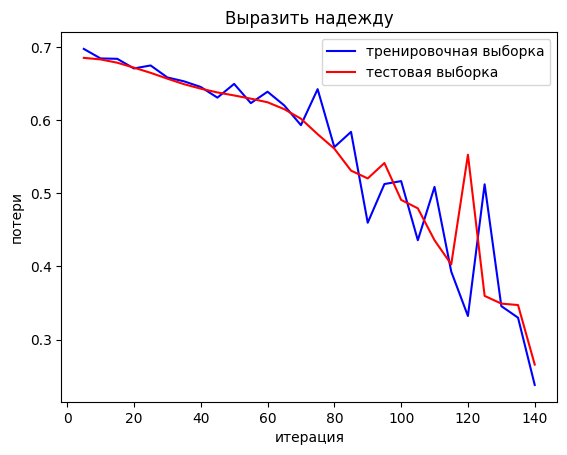

In [ ]:
steps = np.arange(5, 145, 5)

plt.plot(steps, train_loss, '-b', label='тренировочная выборка')
plt.plot(steps, eval_loss, '-r', label='тестовая выборка')

plt.xlabel("итерация")
plt.ylabel("потери")
plt.title('Выразить надежду')

plt.legend()

plt.show()


In [ ]:
len(train_loss), len(eval_loss)

(75, 75)

In [ ]:
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=-1)
labels = predictions.label_ids

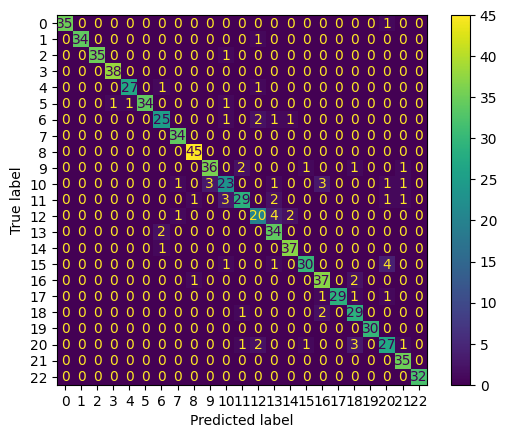

In [ ]:
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Inference

In [ ]:
import pandas as pd
import torch

from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast
from scipy.special import softmax
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/УИР/Интенциональности.csv")

def replace_wrong(s):
  if s == 'Воволечь в диалог':
    return 'Вовлечь в диалог'
  return s

df['label'] = df['label'].apply(replace_wrong)

labels = df.label.unique()
id = range(23)

labels2id = dict(zip(labels, id))
id2labels = dict(zip(id, labels))

In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('/content/drive/MyDrive/УИР/model_fine_tuning/checkpoint-500', device_map = 'cuda')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
def predict(model, tokenizer, text, id2labels):
  device = "cuda" if torch.cuda.is_available() else "cpu"

  encoding = tokenizer(text, return_tensors="pt").to(device)
  outputs = model(**encoding)
  prediction = outputs.logits.argmax(-1)

  probabilities = softmax(outputs['logits'].cpu().detach().numpy()).tolist()[0]
  labels = id2labels.values()

  res = dict()
  prob = dict(zip(labels, probabilities))
  res['probabilities'] = prob
  res['label'] = id2labels[int(prediction)]
  res['text'] = text

  return res

In [ ]:
text = 'Владимир Владимирович, можно задать вопрос?'
x = list(predict(model, tokenizer, text, id2labels)['probabilities'].keys())
y = list(predict(model, tokenizer, text, id2labels)['probabilities'].values())
y

[0.018969295546412468,
 0.002724299905821681,
 0.0031011200044304132,
 0.0031567278783768415,
 0.0026333287823945284,
 0.0025171516463160515,
 0.0032846760004758835,
 0.012119022198021412,
 0.35674309730529785,
 0.11957015097141266,
 0.006754176691174507,
 0.13281723856925964,
 0.0038462721277028322,
 0.007665690965950489,
 0.008444951847195625,
 0.006895811762660742,
 0.1113712340593338,
 0.023572169244289398,
 0.047355618327856064,
 0.0022837305441498756,
 0.01514037698507309,
 0.10632336884737015,
 0.00271050538867712]

Text(0.5, 1.0, 'Владимир Владимирович, можно задать вопрос?')

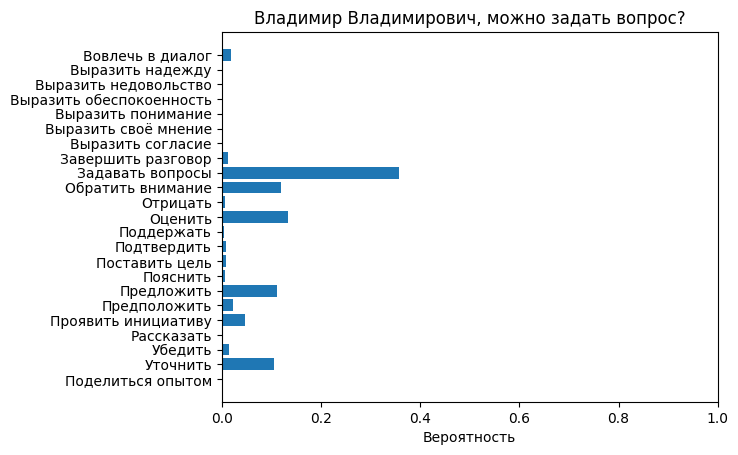

In [ ]:
fig, ax = plt.subplots()

ax.barh(x, y, align='center')
ax.set_yticks(x, x)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Вероятность')
ax.set_xlim(0, 1)
ax.set_title(text)

In [ ]:
mytests = ['Владимир Владимирович, можно задать вопрос?',
'Я этого не делал',
'Я не понял объяснения теоремы. Можно кое - что уточнить',
'Я хочу быть капитаном команды',
'Наша цель на эту лекцию - доказать теорему Вейерштрасса',
'Вы старались, но эту работу я могу оценить только на 2',
'Можно спросить насчет темы следующей лекции?'
]

for test in mytests:
  print(f"{test} \\\\\\\ {predict(model, tokenizer, test, id2labels)['label']}")